In [ ]:
# Library Installation
!pip install --upgrade kaggle
!pip install --upgrade transformers
!pip install --upgrade torch
!pip install --upgrade tweetnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.5-py3-none-any.whl size=111932 sha256=bcbc3b872872635f7b7ac8a1e7c9d1151a4654bc0871e45cafa273fa2750c97f
  Stored in directory: /root/.cache/pip/wheels/09/0f/ab/77c3f5de4d162a047d4ac3e9a8ced7252d17ac1f9f2a42fa08
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

# 0. Setup and Imports

In [ ]:
# Imports
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from google.colab import drive, userdata
import logging
import zipfile
import os
# import tweetnlp
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Parameters

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# # Define file paths
path_csv_source = '/content/drive/Path/To/Data/source'
path_kaggle_json = '/content/drive/Path/To/kaggle.json'
path_save_parquet = '/content/drive/Path/To/Data/Output/twitter_source_union.parquet'

In [ ]:
# Setting up Kaggle credentials
!mkdir -p ~/.kaggle
!cp "{path_kaggle_json}" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 1. Dataset Download and Preparation

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download dataset from Kaggle
api.dataset_download_files('eduardojoslunelli/brazil-elections-2022-twitter', path=path_csv_source, unzip=True)

In [ ]:
# Unzip and extract dataset
path_zip = '/content/drive/Path/To/Data/source/brazil-elections-2022-twitter.zip'

os.makedirs(path_csv_source, exist_ok=True)

with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_csv_source)

## 1.1 Union Dataset

In [ ]:
# Union of datasets from multiple CSV files
dataframes = []

for filename in os.listdir(path_csv_source):
    if filename.endswith('.csv'):
        file_path = os.path.join(path_csv_source, filename)
        df = pd.read_csv(file_path)

        if 'ID' in df.columns:
            df['ID'] = df['ID'].astype(str)
        if 'User_ID' in df.columns:
            df['User_ID'] = df['User_ID'].astype(str)

        df['origin'] = filename
        dataframes.append(df)

In [ ]:
# Concatenate all dataframes and process
df_concatenado = pd.concat(dataframes, ignore_index=True)
df_concatenado['Emoji'] = df_concatenado['Emoji'].str.replace(r'[\[\]\',]', '', regex=True)
df_concatenado['Tweet_Emoji'] = df_concatenado['Tweet'] + ' ' + df_concatenado['Emoji']
df_concatenado['Tweet_Emoji'] = df_concatenado['Tweet_Emoji'].astype(str)
df_concatenado.to_parquet(path_save_parquet)

In [ ]:
# Load processed data
df = pd.read_parquet(path_save_parquet)
print(f"Total rows in dataset: {len(df)}")

Total rows in dataset: 512439


# 3. Model Load and Inference (tweetnlp)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Load multilingual sentiment analysis model
model = tweetnlp.load_model('sentiment', multilingual=True)

In [ ]:
# Function to process a batch of tweets for sentiment analysis
def process_batch(tweets, device):
    sentiments = []
    probabilities = []
    with torch.no_grad():
        for tweet in tweets:
            try:
                result = model.sentiment(tweet, return_probability=True)
                sentiments.append(result['label'])
                probabilities.append(result['probability'])
            except Exception as e:
                logging.error(f"Error processing tweet: {tweet}\n{e}")
                sentiments.append(None)
                probabilities.append(None)
    return sentiments, probabilities

In [ ]:
# Batch processing with parallelism
batch_size = 200  # Adjust based on available resources
results = []
with tqdm(np.array_split(df['Tweet_Emoji'], len(df) // batch_size)) as batches:
    for batch in batches:
        results.append(process_batch(batch, device))

  0%|          | 0/2562 [00:00<?, ?it/s]

In [ ]:
# Extract results and add to dataframe
df['Sentiment'] = [item for sublist in results for item in sublist[0]]
df['Sentiment_Score'] = [item for sublist in results for item in sublist[1]]

In [ ]:
# Save results
path_save_parquet = '/content/drive/Path/To/Data/Output/tweetnlp_results.parquet'
df.to_parquet(path_save_parquet)
df.head(20)

,ID,Time,User,Tweet,Hashtags,User_ID,Followers_Count,Created_at,Retweet_count,Favorite_count,Verified,Emoji,Candidato,origin,Tweet_Emoji,Sentiment,Sentiment_Score
0,1576328139474497536,2022-10-01 18:48:09,Daniellagomesss,hj ultimo dia bolsonaro sendo presidente,[],1097533347998433280,143,2019-02-18 13:28:36,0,0,False,,['Bolsonaro'],Datafolha_Primeiro_Turno.csv,hj ultimo dia bolsonaro sendo presidente,neutral,"{'negative': 0.18729355931282043, 'neutral': 0..."
1,1576328139629682691,2022-10-01 18:48:09,o_polaco_,australia lula presidente brasil,[],87255875,1132,2009-11-03 15:52:53,0,0,False,,['Lula'],Datafolha_Primeiro_Turno.csv,australia lula presidente brasil,neutral,"{'negative': 0.3895485997200012, 'neutral': 0...."
2,1576328139512238080,2022-10-01 18:48:09,miguel_soliva,vou dar opiniao sem pedida vi pesquisas contin...,[],1190844709977112576,110,2019-11-03 01:15:03,0,0,False,,['Bolsonaro'],Datafolha_Primeiro_Turno.csv,vou dar opiniao sem pedida vi pesquisas contin...,neutral,"{'negative': 0.2347511351108551, 'neutral': 0...."
3,1576328140003368960,2022-10-01 18:48:09,killingspfc,mato hoje pois preciso votar amanha lula,[],1008733593194188801,388,2018-06-18 12:30:04,0,0,False,,['Lula'],Datafolha_Primeiro_Turno.csv,mato hoje pois preciso votar amanha lula,negative,"{'negative': 0.4711339473724365, 'neutral': 0...."
4,1576328139923677185,2022-10-01 18:48:09,ecunha01,bora precisamos 501 forca urgente datafolha ip...,[],366378363,3746,2011-09-01 23:16:08,0,0,False,,['Lula'],Datafolha_Primeiro_Turno.csv,bora precisamos 501 forca urgente datafolha ip...,neutral,"{'negative': 0.22022655606269836, 'neutral': 0..."
5,1576328140066271233,2022-10-01 18:48:10,AlcidesAlmeida9,farah lula presidente amanha,[],4091489309,5260,2015-11-01 14:43:21,0,0,False,,['Lula'],Datafolha_Primeiro_Turno.csv,farah lula presidente amanha,neutral,"{'negative': 0.23543977737426758, 'neutral': 0..."
6,1576328141064515584,2022-10-01 18:48:10,_m666nchild,vem pro curintia comigo lula amg,[],894181501398650880,893,2017-08-06 10:00:57,0,0,False,😈 😈 😈,['Lula'],Datafolha_Primeiro_Turno.csv,vem pro curintia comigo lula amg 😈 😈 😈,neutral,"{'negative': 0.210218146443367, 'neutral': 0.4..."
7,1576328138556334080,2022-10-01 18:48:09,Magela69,buritis ro fechado bolsonaro,[],1456993203358478439,223,2021-11-06 11:34:35,0,0,False,,['Bolsonaro'],Datafolha_Primeiro_Turno.csv,buritis ro fechado bolsonaro,negative,"{'negative': 0.43410083651542664, 'neutral': 0..."
8,1576328141106122752,2022-10-01 18:48:10,thepoetriste,lula presidente amanha 1,[],1174475269371043841,1706,2019-09-18 21:08:30,0,0,False,,['Lula'],Datafolha_Primeiro_Turno.csv,lula presidente amanha 1,neutral,"{'negative': 0.21002113819122314, 'neutral': 0..."
9,1576328141450067968,2022-10-01 18:48:10,Jackye_Correia,povo trabalhadores brasileiros gratos atende...,[],1684109402,746,2013-08-19 17:19:22,0,0,False,,['Lula'],Datafolha_Primeiro_Turno.csv,povo trabalhadores brasileiros gratos atende...,positive,"{'negative': 0.11995505541563034, 'neutral': 0..."


# 4. Evaluate Model

In [ ]:
# Load processed data
df = pd.read_parquet(path_save_parquet)
print(f"Total rows in dataset: {len(df)}")

Total rows in dataset: 512439


In [ ]:
# Re-writing the updated confidence_threshold_analysis function to handle the new format of Sentiment_Score column values

import matplotlib.pyplot as plt

def confidence_threshold_analysis_updated(df, score_column='Sentiment_Score', sentiment='positive'):
    """
    Perform confidence threshold analysis on the sentiment scores.

    :param df: DataFrame containing the sentiment scores.
    :param score_column: Column name where sentiment scores are stored.
    :param sentiment: The sentiment to analyze ('positive', 'neutral', or 'negative').
    """

    # Extracting the confidence score for the specified sentiment
    confidence_scores = df[score_column].apply(lambda x: x.get(sentiment) if isinstance(x, dict) else None).dropna()

    # Plot histogram of confidence scores for the specified sentiment
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=50, color='skyblue', edgecolor='black')

    # Setting the title and source according to the guidelines
    plt.xlabel('Score de Confiança', fontsize=10)
    plt.ylabel('Frequência', fontsize=10)


    # Additional formatting
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'/content/sample_data/bubble_bolsonaro.jpg', dpi=600)
    plt.show()

    # Analyze thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    for threshold in thresholds:
        count_above_threshold = confidence_scores[confidence_scores >= threshold].shape[0]
        proportion = count_above_threshold / len(confidence_scores)
        print(f"Proportion of {sentiment} predictions with confidence >= {threshold}: {proportion:.2f}")

In [ ]:
confidence_threshold_analysis_updated(df, 'Sentiment_Score', 'positive')

KeyError: 'Sentiment_Score'

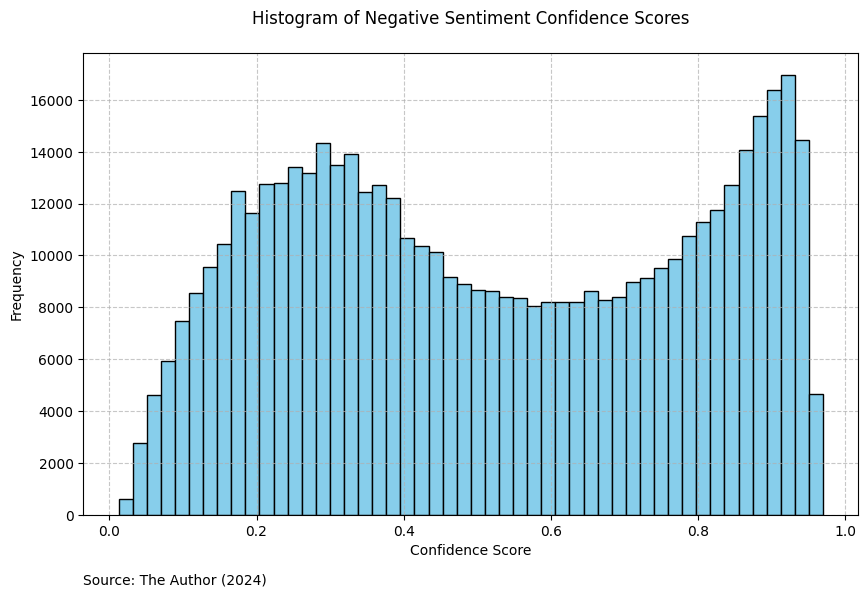

Proportion of negative predictions with confidence >= 0.5: 0.50
Proportion of negative predictions with confidence >= 0.6: 0.41
Proportion of negative predictions with confidence >= 0.7: 0.32
Proportion of negative predictions with confidence >= 0.8: 0.23
Proportion of negative predictions with confidence >= 0.9: 0.09


In [ ]:
confidence_threshold_analysis_updated(df, 'Sentiment_Score', 'negative')

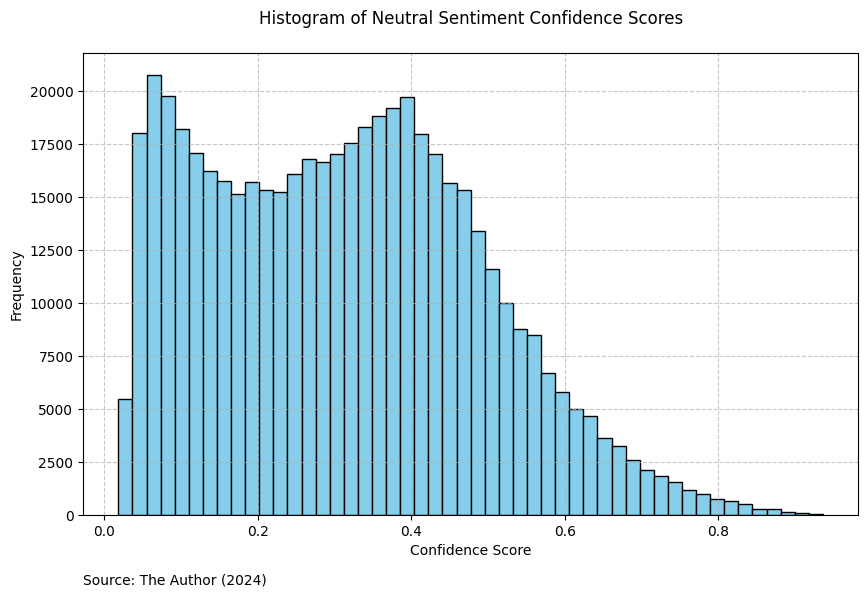

Proportion of neutral predictions with confidence >= 0.5: 0.15
Proportion of neutral predictions with confidence >= 0.6: 0.06
Proportion of neutral predictions with confidence >= 0.7: 0.02
Proportion of neutral predictions with confidence >= 0.8: 0.00
Proportion of neutral predictions with confidence >= 0.9: 0.00


In [ ]:
confidence_threshold_analysis_updated(df, 'Sentiment_Score', 'neutral')


1. **Positive Sentiment**:
   - The proportions decrease significantly as the confidence threshold increases.
   - Only 6% of 'positive' predictions are made with a confidence level of 0.5 or higher, and this percentage drops to nearly 0% at a confidence level of 0.9.
   - This suggests that the model is less confident in making 'positive' predictions.

2. **Neutral Sentiment**:
   - Similar to 'positive', the proportions decrease as the threshold increases.
   - 15% of 'neutral' predictions have a confidence level of 0.5 or higher, but this also drops to almost 0% at 0.9.
   - The model is somewhat more confident in making 'neutral' predictions compared to 'positive', but still not highly confident.

3. **Negative Sentiment**:
   - The model seems significantly more confident in its 'negative' predictions.
   - 50% of 'negative' predictions have a confidence level of 0.5 or higher, and even at a high threshold of 0.9, 9% of predictions are still confident.
   - This indicates that the model is most confident when predicting negative sentiments.

### Interpretation
- Your model is most confident in predicting negative sentiments, followed by neutral and then positive sentiments.
- The low confidence in positive and neutral predictions could be due to various factors, like imbalanced training data, inherent difficulties in distinguishing these sentiments, or the nature of the dataset itself.

# 5. Model Load and Inference (pysentimiento)

In [ ]:
!pip install pysentimiento

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=cbdd2fa5049504ac20aed887157ee5acfcea34dccc126c09bc3b5d51861fb962
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
from pysentimiento import create_analyzer
# Initialize pysentimiento analyzer for Portuguese
analyzer = create_analyzer(task="sentiment", lang="pt")

loading configuration file https://huggingface.co/pysentimiento/bertweet-pt-sentiment/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/40c336310566a1e528152d4782ceb4cff9f1e933006bdb0cf0b077e3c2dbcd9b.4b57ceb97eb3005ad978c2c1a56c1b114eede210a826f18ec4f5b586b5d041c8
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/bertweet-pt-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

In [ ]:
path_save_parquet = '/content/drive/Path/To/Data/Output/twitter_source_union.parquet'

df = pd.read_parquet(path_save_parquet)

In [ ]:
def process_batch_pysentimiento(tweets):
    sentiments = []
    probabilities = []
    for tweet in tweets:
        try:
            result = analyzer.predict(tweet)
            sentiments.append(result.output)
            probabilities.append(result.probas[result.output])
        except Exception as e:
            logging.error(f"Error processing tweet: {tweet}\n{e}")
            sentiments.append(None)
            probabilities.append(None)
    return sentiments, probabilities

In [ ]:
batch_size = 200  # Adjust based on available resources
results = []
with tqdm(np.array_split(df['Tweet_Emoji'], len(df) // batch_size)) as batches:
    for batch in batches:
        results.append(process_batch_pysentimiento(batch))

  0%|          | 0/2562 [00:00<?, ?it/s]

In [ ]:
# Extract results and add to dataframe
df['pysentimiento_Sentiment'] = [item for sublist in results for item in sublist[0]]
df['pysentimiento_Sentiment_Score'] = [item for sublist in results for item in sublist[1]]

In [ ]:
# Save results
path_save_parquet_pysentimiento = '/content/drive/Path/To/Data/pysentimiento_results.parquet'
df.to_parquet(path_save_parquet_pysentimiento)
df.head(20)

KeyboardInterrupt: 

In [ ]:
# Load processed data
path_save_parquet_pysentimiento = '/content/drive/Path/To/Data/pysentimiento_results.parquet'
df = pd.read_parquet(path_save_parquet_pysentimiento)
print(f"Total rows in dataset: {len(df)}")

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet file size is 0 bytes

In [ ]:
# Adapting the confidence_threshold_analysis_updated function for use with pysentimiento dataframe

def confidence_threshold_analysis_pysentimiento(df, sentiment_column='pysentimiento_Sentiment', score_column='pysentimiento_Sentiment_Score', sentiment='POS'):
    """
    Perform confidence threshold analysis on pysentimiento sentiment scores.

    :param df: DataFrame containing the sentiment scores and labels.
    :param sentiment_column: Column name where sentiment labels are stored.
    :param score_column: Column name where sentiment scores are stored.
    :param sentiment: The sentiment to analyze ('POS', 'NEU', or 'NEG').
    """

    # Filter the dataframe for the specified sentiment
    filtered_df = df[df[sentiment_column] == sentiment]

    # Extracting the confidence scores
    confidence_scores = filtered_df[score_column].dropna()

    # Plot histogram of confidence scores for the specified sentiment
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=50, color='skyblue', edgecolor='black')

    # Setting the title and source according to the guidelines
    plt.title(f'Histogram of {sentiment} Sentiment Confidence Scores\n', fontsize=12)
    plt.xlabel('Confidence Score', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

    # Additional formatting
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'/content/sample_data/bubble_bolsonaro.jpg', dpi=600)
    plt.show()

    # Analyze thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    for threshold in thresholds:
        count_above_threshold = confidence_scores[confidence_scores >= threshold].shape[0]
        proportion = count_above_threshold / len(confidence_scores)
        print(f"Proportion of {sentiment} predictions with confidence >= {threshold}: {proportion:.2f}")

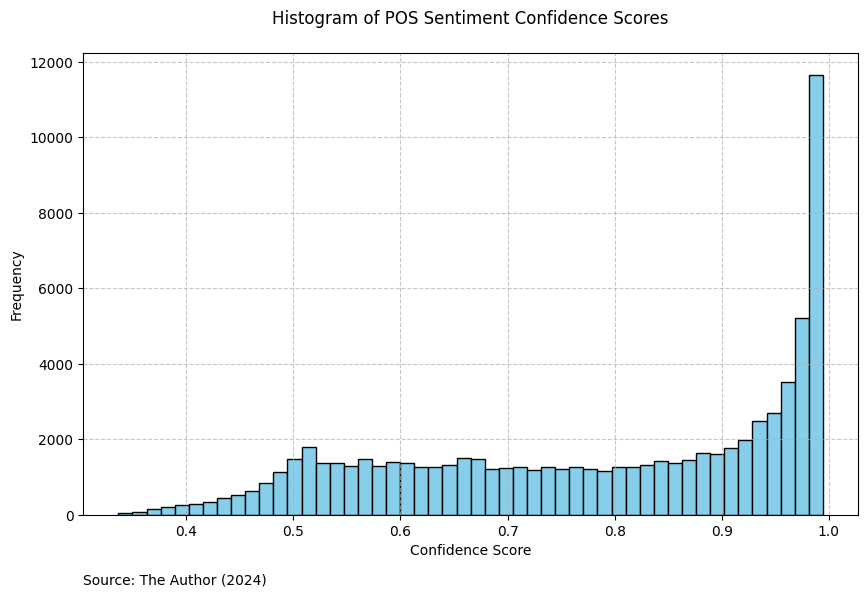

Proportion of POS predictions with confidence >= 0.5: 0.93
Proportion of POS predictions with confidence >= 0.6: 0.79
Proportion of POS predictions with confidence >= 0.7: 0.65
Proportion of POS predictions with confidence >= 0.8: 0.53
Proportion of POS predictions with confidence >= 0.9: 0.39


In [ ]:
confidence_threshold_analysis_pysentimiento(df, 'pysentimiento_Sentiment', 'pysentimiento_Sentiment_Score', 'POS')

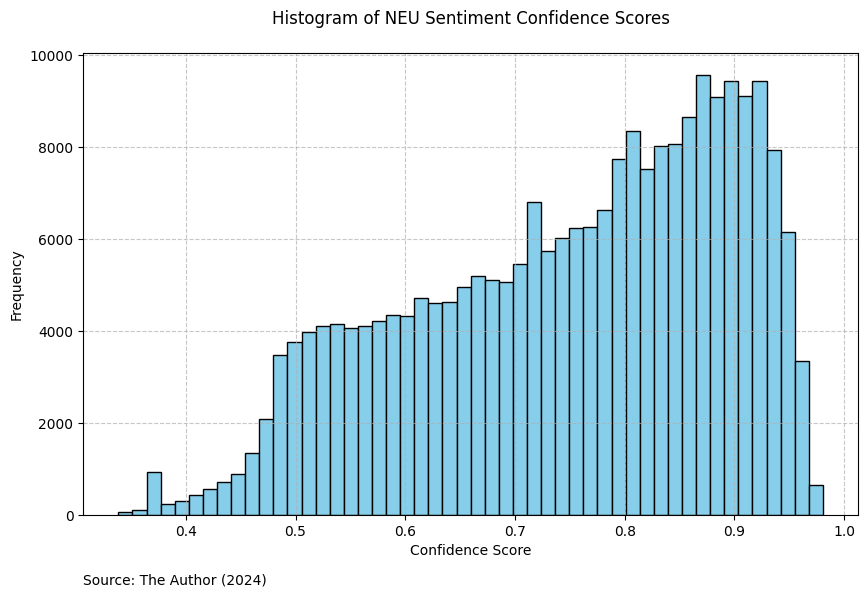

Proportion of NEU predictions with confidence >= 0.5: 0.94
Proportion of NEU predictions with confidence >= 0.6: 0.81
Proportion of NEU predictions with confidence >= 0.7: 0.65
Proportion of NEU predictions with confidence >= 0.8: 0.44
Proportion of NEU predictions with confidence >= 0.9: 0.16


In [ ]:
confidence_threshold_analysis_pysentimiento(df, 'pysentimiento_Sentiment', 'pysentimiento_Sentiment_Score', 'NEU')


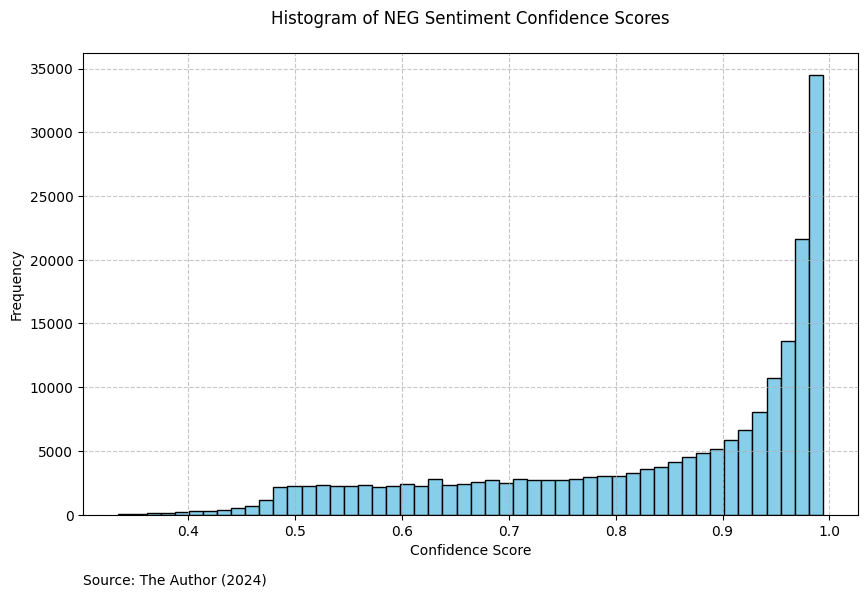

Proportion of NEG predictions with confidence >= 0.5: 0.96
Proportion of NEG predictions with confidence >= 0.6: 0.88
Proportion of NEG predictions with confidence >= 0.7: 0.78
Proportion of NEG predictions with confidence >= 0.8: 0.67
Proportion of NEG predictions with confidence >= 0.9: 0.52


In [ ]:
confidence_threshold_analysis_pysentimiento(df, 'pysentimiento_Sentiment', 'pysentimiento_Sentiment_Score', 'NEG')



1. **Positive (POS) Sentiment**:
   - Very high confidence at 0.5 threshold (93%) which gradually decreases as the threshold increases.
   - Still maintains a reasonably high confidence (39%) even at the high threshold of 0.9.

2. **Negative (NEG) Sentiment**:
   - Extremely high confidence at 0.5 threshold (96%), slightly higher than POS sentiment.
   - Confidence remains over 50% even at the 0.9 threshold.

3. **Neutral (NEU) Sentiment**:
   - Similar to POS, high confidence at 0.5 threshold (94%).
   - Notably, the confidence drops more significantly at higher thresholds compared to POS and NEG, with only 16% at the 0.9 threshold.

### Interpretation
- The `pysentimiento` model shows a strong ability to confidently classify sentiments at lower thresholds.
- For POS and NEG sentiments, the model remains relatively confident even at higher thresholds.
- The NEU sentiment shows a steeper decline in confidence at higher thresholds, suggesting that the model is less certain about NEU classifications as the demand for confidence increases.

### Comparison with `tweetnlp` Results:
- The `pysentimiento` model appears to have higher overall confidence levels compared to the `tweetnlp` model, especially in the positive and negative categories.
- The `tweetnlp` model showed a particularly low confidence in positive predictions, which is not the case with `pysentimiento`.
